In [59]:
import shap
from datasets import load_dataset
from src.utils import MODEL_NAME_TO_DESC_DICT, format_text_pred, prepare_text
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForSequenceClassification, pipeline, AutoTokenizer
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
from transformers.pipelines.pt_utils import KeyDataset
from tqdm import tqdm

import lightgbm as lgb

In [3]:
shap_dict = {}
for i in range(8):
    entry = np.load(f'../shap_vals/imdb_genre/imdb_genre_{i}_shap_values.npy')
    entry = [entry[0], entry[1]]
    shap_dict[f'imdb_genre_{i}'] = entry

In [113]:
test_df = load_dataset('james-burton/imdb_genre_prediction2', split='test').to_pandas()
tab_cols = ['Year','Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)','Metascore', 'Rank']
text_col = ['Description']

Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


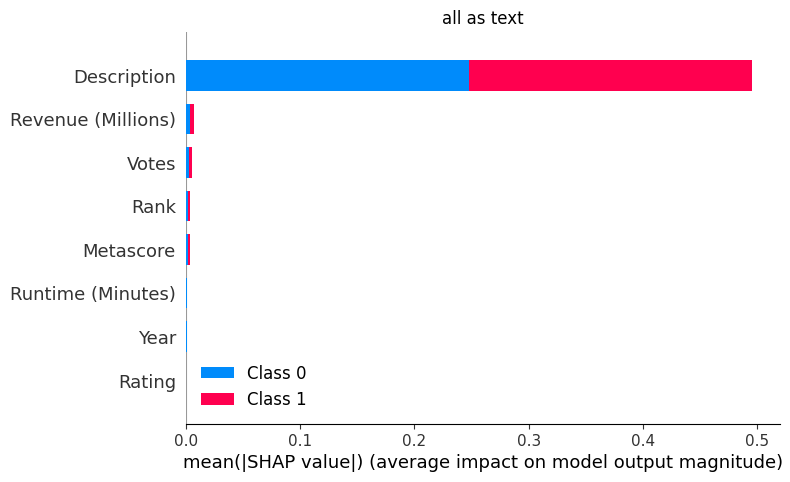

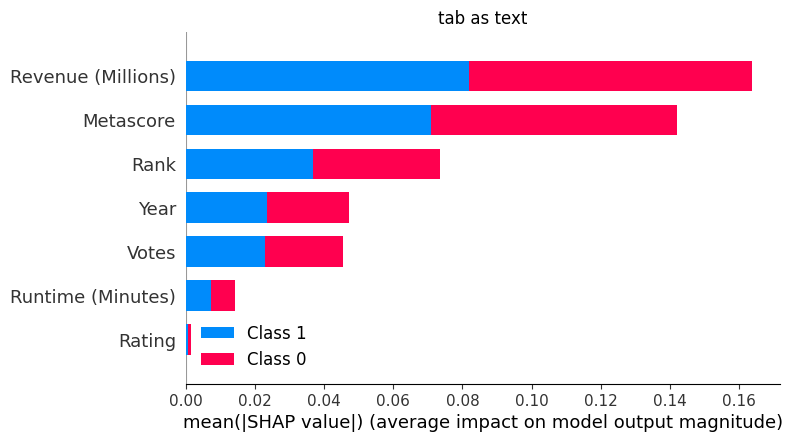

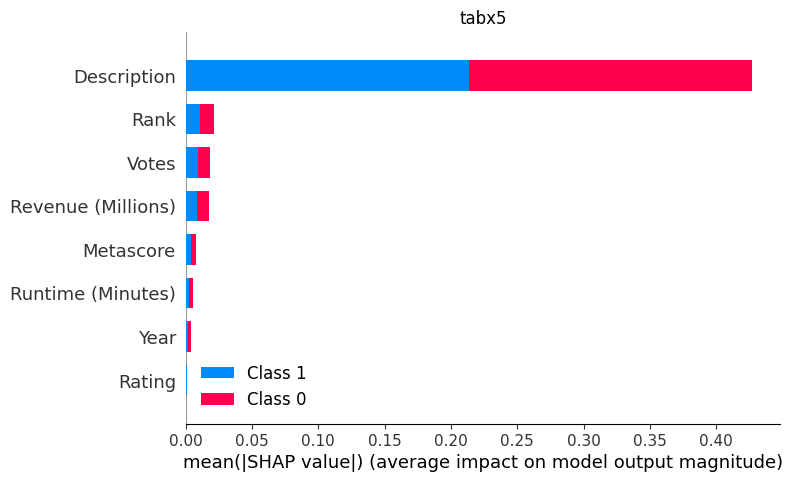

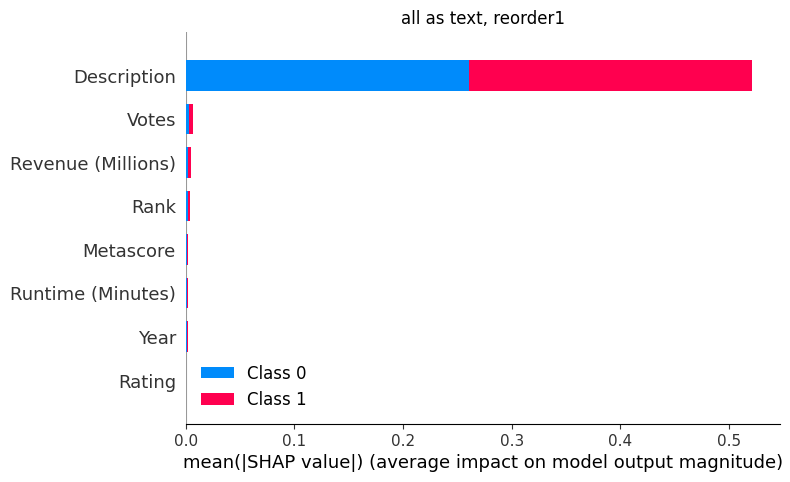

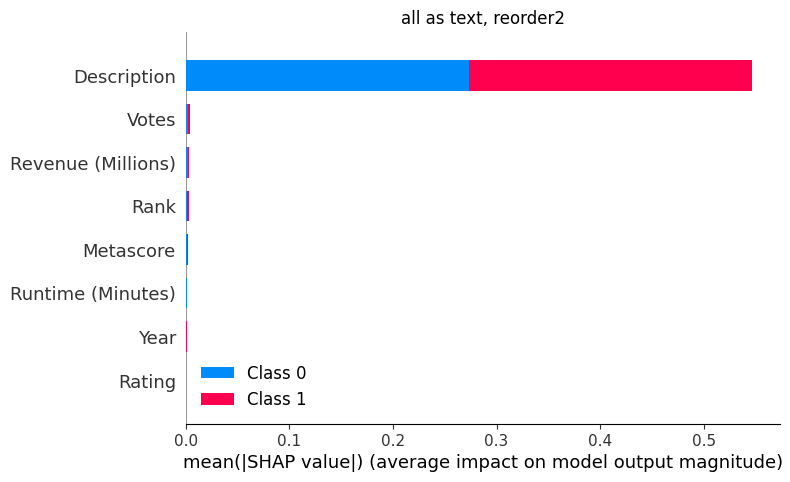

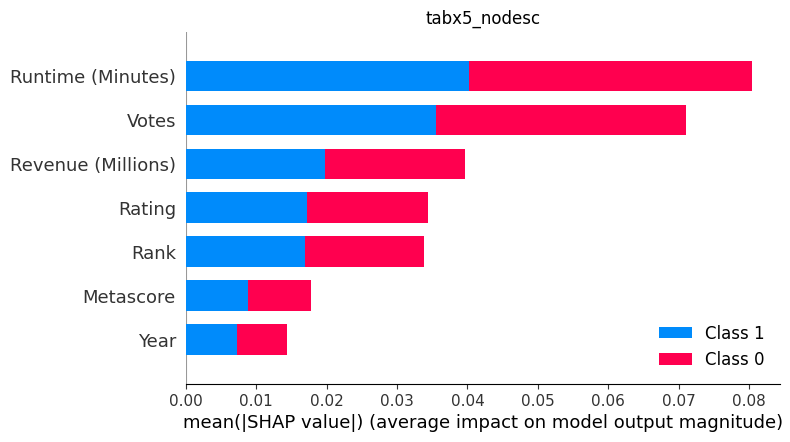

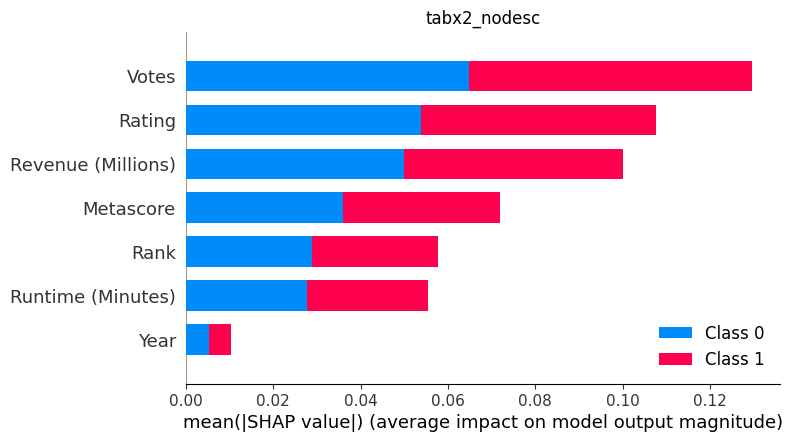

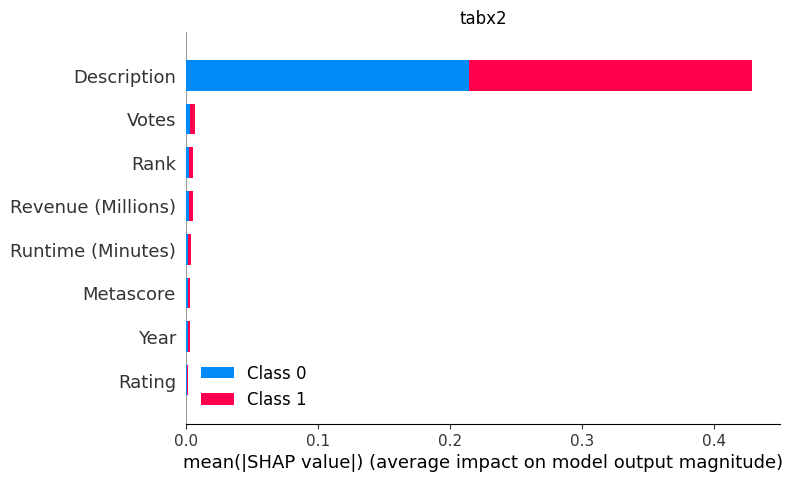

In [5]:

# 'imdb_genre_0' | 'imdb_genre_7' | 'imdb_genre_2' | 'ensemble_25' | 'ensemble_50' | 'ensemble_75' | 'ensemble_0'
def gen_summary_plot(model_name, shap_values):
    match model_name:
        case 'imdb_genre_1' | 'imdb_genre_6' | 'imdb_genre_5'| 'tab_lgb':
            cols = tab_cols
        case 'imdb_genre_3':
            cols = ['Votes', 'Revenue (Millions)', 'Metascore', 'Rank', 'Description', 'Year', 'Runtime (Minutes)', 'Rating']
        case 'imdb_genre_4':
            cols = ['Description', 'Rank', 'Metascore', 'Revenue (Millions)', 'Votes', 'Rating', 'Runtime (Minutes)', 'Year']
        case _:
            cols = tab_cols + text_col
        
    shap.summary_plot(shap_values, test_df[cols], plot_type="bar",show=False)
    plt.title(MODEL_NAME_TO_DESC_DICT.get(model_name, model_name))
    plt.show()
    
for model_name, shap_values in shap_dict.items():
    gen_summary_plot(model_name, shap_values)

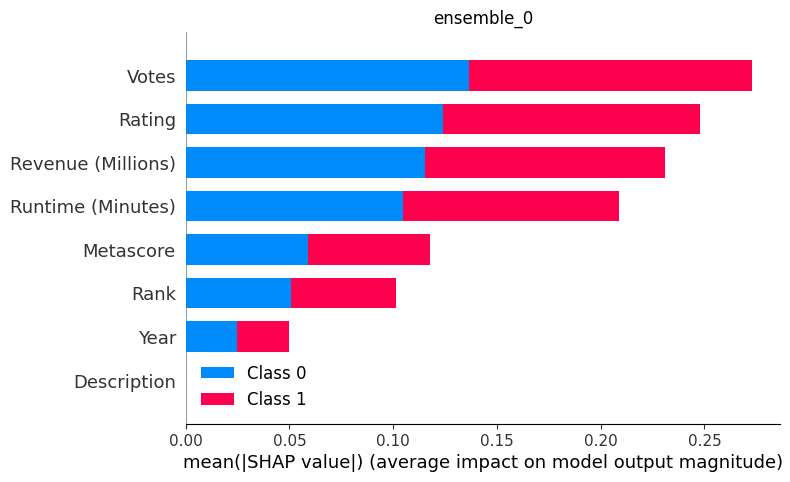

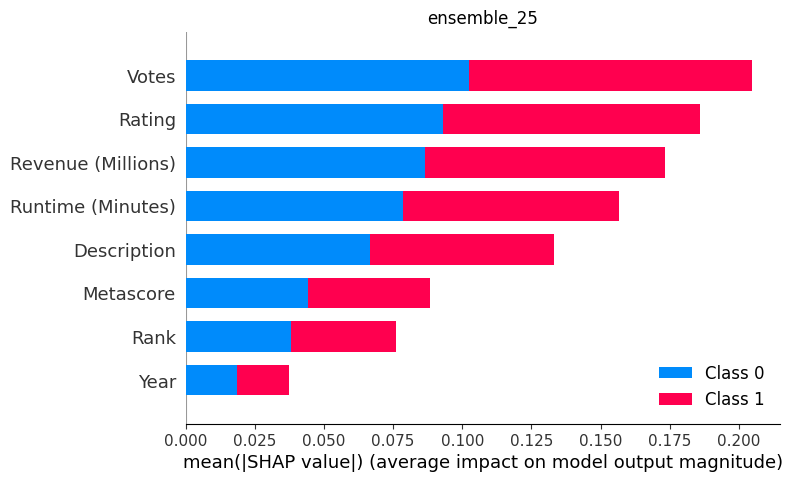

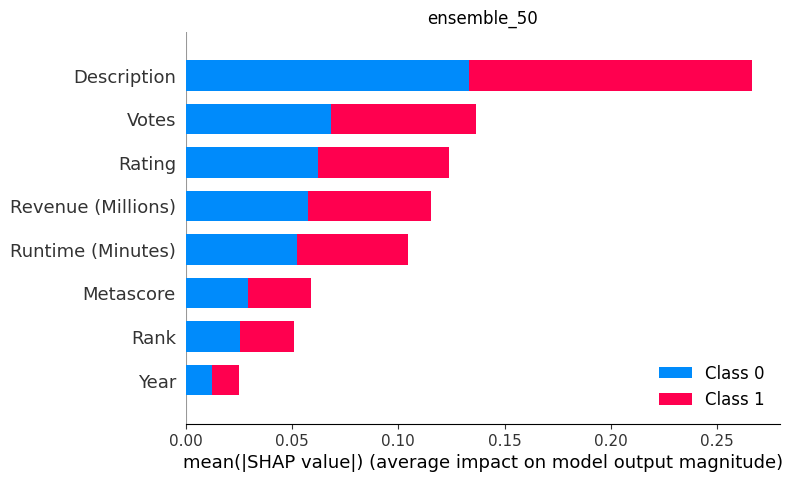

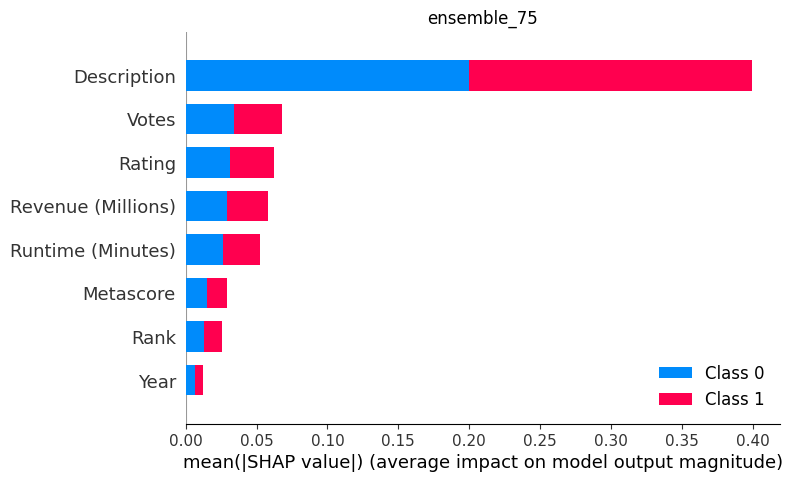

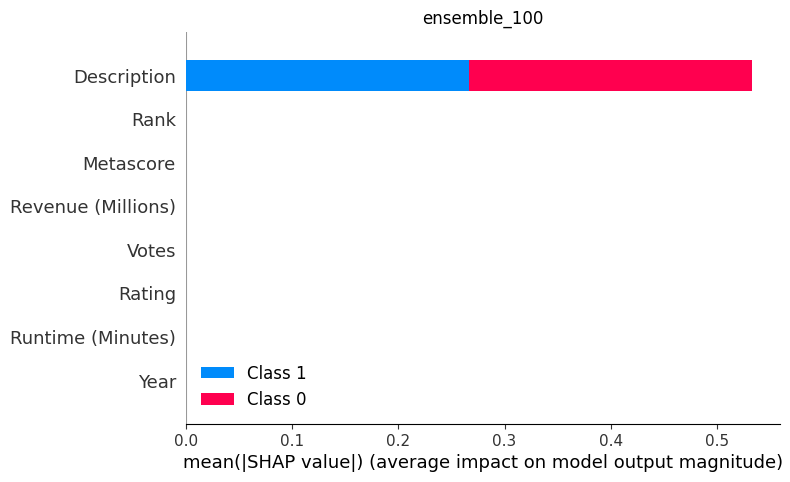

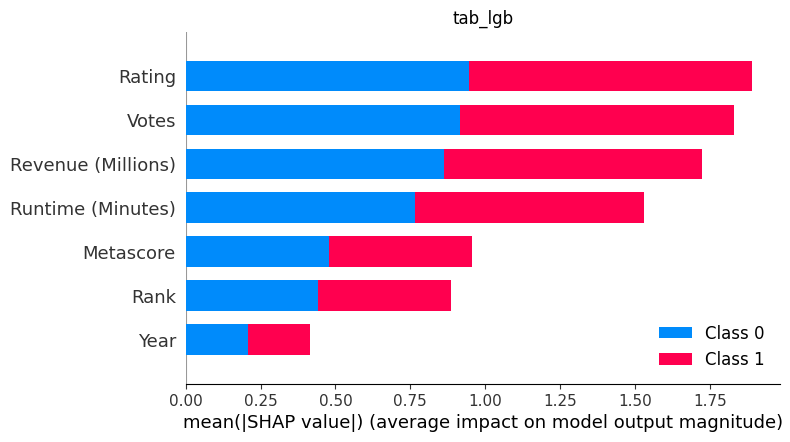

In [6]:
another_shap_dict = {}
for model_name in ['ensemble_0', 'ensemble_25', 'ensemble_50', 'ensemble_75', 'ensemble_100', 'tab_lgb']:
    shap_values = np.load(f'../shap_vals/imdb_genre/{model_name}.npy')
    shap_values = [shap_values[0], shap_values[1]]
    another_shap_dict[model_name] = shap_values
    
for model_name, shap_values in another_shap_dict.items():
    gen_summary_plot(model_name, shap_values)

## Mean(|shap value|) in a dataframe 

In [7]:


models = ['ensemble_0', 'ensemble_25', 'ensemble_50', 'ensemble_75', 'ensemble_100']
for model in models:
    b = np.mean(np.abs(another_shap_dict[model][1]), axis=0)
    b = np.expand_dims(b, axis=0)
    if model == 'ensemble_0':
        a = b
    else:
        a = np.concatenate([a, b], axis=0)
    
abs_df = pd.DataFrame(a, columns=tab_cols + text_col, index=models)

for model in models:
    b = np.mean(another_shap_dict[model][1], axis=0)
    b = np.expand_dims(b, axis=0)
    if model == 'ensemble_0':
        a = b
    else:
        a = np.concatenate([a, b], axis=0)
    
df = pd.DataFrame(a, columns=tab_cols + text_col, index=models)

In [8]:
abs_df.round(2)

,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Rank,Description
ensemble_0,0.02,0.10,0.12,0.14,0.12,0.06,0.05,0.00
ensemble_25,0.02,0.08,0.09,0.10,0.09,0.04,0.04,0.07
ensemble_50,0.01,0.05,0.06,0.07,0.06,0.03,0.03,0.13
ensemble_75,0.01,0.03,0.03,0.03,0.03,0.01,0.01,0.20
ensemble_100,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27


In [9]:
print(f"Mean absolute difference: {np.abs(another_shap_dict['ensemble_25'][1][:,:7] - another_shap_dict['ensemble_0'][1][:,:7]*0.75).mean():.16f}")
print(f"Mean absolute difference: {np.abs(another_shap_dict['ensemble_50'][1][:,:7] - another_shap_dict['ensemble_0'][1][:,:7]*0.5).mean():.16f}")
print(f"Mean absolute difference: {np.abs(another_shap_dict['ensemble_75'][1][:,:7] - another_shap_dict['ensemble_0'][1][:,:7]*0.25).mean():.16f}")
print(f"Mean absolute difference: {np.abs(another_shap_dict['ensemble_25'][1][:,:7] - another_shap_dict['ensemble_0'][1][:,:7]*0.75).mean():.16f}")

Mean absolute difference: 0.0000000000000002
Mean absolute difference: 0.0000000000000002
Mean absolute difference: 0.0000000000000002
Mean absolute difference: 0.0000000000000002


Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


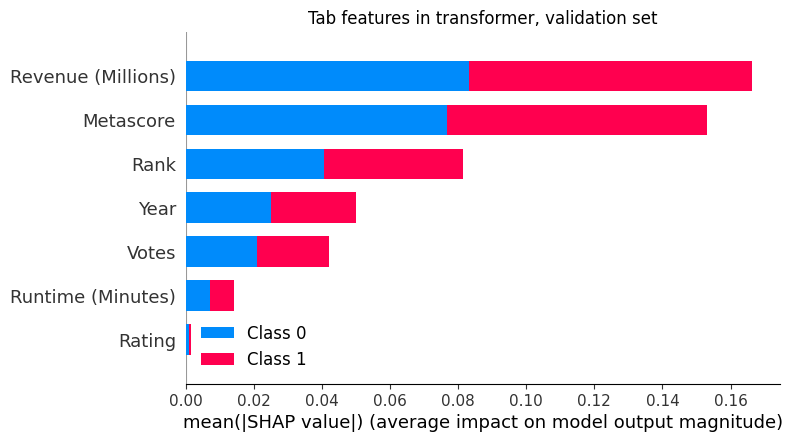

In [10]:
val_shap_vals = np.load('../shap_vals/imdb_genre/imdb_genre_1_val_shap_values.npy')
val_shap_vals = [val_shap_vals[0], val_shap_vals[1]]

val_df = load_dataset('james-burton/imdb_genre_prediction2', split='validation').to_pandas()

shap.summary_plot(val_shap_vals, val_df[tab_cols], plot_type="bar",show=False)
plt.title('Tab features in transformer, validation set')
plt.show()

Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


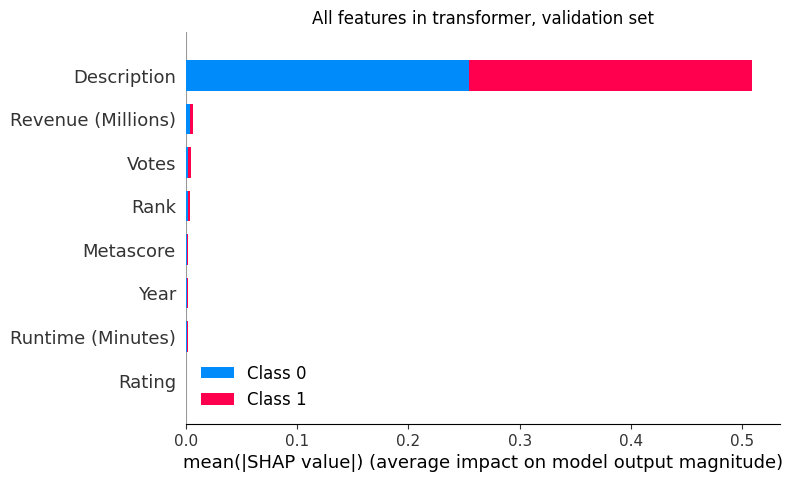

In [11]:
val_shap_vals = np.load('../shap_vals/imdb_genre/imdb_genre_0_val_shap_values.npy')
val_shap_vals = [val_shap_vals[0], val_shap_vals[1]]

val_df = load_dataset('james-burton/imdb_genre_prediction2', split='validation').to_pandas()

shap.summary_plot(val_shap_vals, val_df[tab_cols+text_col], plot_type="bar",show=False)
plt.title('All features in transformer, validation set')
plt.show()

In [60]:
train_df = load_dataset('james-burton/imdb_genre_prediction2', split='train').to_pandas()
train_df

Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


,Rank,Title,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Genre_is_Drama
0,641,The Pursuit of Happyness,A struggling salesman takes custody of his son...,Gabriele Muccino,"Will Smith, Thandie Newton, Jaden Smith, Brian...",2006,117,8.0,361105,162.590000,64.0,1
1,187,Billy Lynn's Long Halftime Walk,19-year-old Billy Lynn is brought home for a v...,Ang Lee,"Joe Alwyn, Garrett Hedlund, Arturo Castro, Mas...",2016,113,6.3,11944,1.720000,53.0,1
2,262,Black Swan,A committed dancer wins the lead role in a pro...,Darren Aronofsky,"Natalie Portman, Mila Kunis, Vincent Cassel,Wi...",2010,108,8.0,581518,106.950000,79.0,1
3,458,Get Hard,When millionaire James King is jailed for frau...,Etan Cohen,"Will Ferrell, Kevin Hart, Alison Brie, T.I.",2015,100,6.0,95119,90.350000,34.0,0
4,651,Sweeney Todd: The Demon Barber of Fleet Street,"The infamous story of Benjamin Barker, a.k.a. ...",Tim Burton,"Johnny Depp, Helena Bonham Carter, Alan Rickma...",2007,116,7.4,296289,52.880000,83.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
675,394,Whisky Galore,Scottish islanders try to plunder cases of whi...,Gillies MacKinnon,"Tim Pigott-Smith, Naomi Battrick, Ellie Kendri...",2016,98,5.0,102,82.877094,43.0,0
676,914,Coherence,Strange things begin to happen when a group of...,James Ward Byrkit,"Emily Baldoni, Maury Sterling, Nicholas Brendo...",2013,89,7.2,66265,0.070000,65.0,0
677,200,Central Intelligence,After he reconnects with an awkward pal from h...,Rawson Marshall Thurber,"Dwayne Johnson, Kevin Hart, Danielle Nicolet, ...",2016,107,6.3,97082,127.380000,52.0,0
678,211,San Andreas,In the aftermath of a massive earthquake in Ca...,Brad Peyton,"Dwayne Johnson, Carla Gugino, Alexandra Daddar...",2015,114,6.1,161396,155.180000,43.0,1
